## Error Analysis

We use the finegrained task  here



In [2]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Obs

`text` hace referencia al contexto del tweet del diario
`title` al título de la noticia (extraído del artículo)

In [3]:


evaluations = {
}
for model_name, path in [
    ('none-ft', "../evaluations/betonews_fine_none.json"),   
    ('text-ft', "../evaluations/betonews_fine_text.json"),   
    ('body-ft', "../evaluations/betonews_fine_body.json"),   
    ]:

    with open(path) as f:
        evaluations[model_name] = json.load(f)

for key, evals in evaluations.items():
    print(f"We have {len(evals['metrics'])} {key} evaluations")


We have 10 none-ft evaluations
We have 10 text-ft evaluations
We have 15 body-ft evaluations


In [4]:
import numpy as np
from hatedetection import extended_hate_categories

df = test_dataset.to_pandas().set_index("id")
df["HATEFUL"] = df[extended_hate_categories].any(1)

column_names = [x+"_pred" for x in extended_hate_categories]

df[column_names] = (np.array(evaluations["text-ft"]["predictions"]) > 0).mean(0)
df["HATEFUL_pred"] = (df[column_names] > 0.5).any(1)

df

,title,text,article_text,HATEFUL,body,CALLS,WOMEN,LGBTI,RACISM,CLASS,...,CALLS_pred,WOMEN_pred,LGBTI_pred,RACISM_pred,CLASS_pred,POLITICS_pred,DISABLED_pred,APPEARANCE_pred,CRIMINAL_pred,HATEFUL_pred
id,,,,,,,,,,,,,,,,,,,,,
397703,Mora Godoy cierra su escuela de tango y remata...,@usuario Ojalá se funda y cague de hambre,Mora Godoy cierra su escuela de tango y remata...,False,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
397704,Mora Godoy cierra su escuela de tango y remata...,@usuario Faltó que se enganchó al hijo de sofo...,Mora Godoy cierra su escuela de tango y remata...,True,Puede marcar con justeza la fecha de inicio de...,0,1,0,0,0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
397705,Mora Godoy cierra su escuela de tango y remata...,"@usuario y bue, que le vaya a llorar a Cristin...",Mora Godoy cierra su escuela de tango y remata...,False,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
397706,Mora Godoy cierra su escuela de tango y remata...,@usuario @usuario Jodete. Macri te hizo conoce...,Mora Godoy cierra su escuela de tango y remata...,False,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
397707,Mora Godoy cierra su escuela de tango y remata...,"@usuario Que se joda, es su gobierno el que el...",Mora Godoy cierra su escuela de tango y remata...,False,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361071,Nahir Galarza sumó a una abogada feminista a s...,@usuario Con esa varita q no rompe un plato ni...,Nahir Galarza sumó a una abogada feminista a s...,False,"La defensa de Nahir Galarza, condenada el 3 de...",0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
361072,Nahir Galarza sumó a una abogada feminista a s...,@usuario No las entiendo a estas pelotudas. So...,Nahir Galarza sumó a una abogada feminista a s...,True,"La defensa de Nahir Galarza, condenada el 3 de...",0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
361073,Nahir Galarza sumó a una abogada feminista a s...,@usuario Lo mató por qué es macho!,Nahir Galarza sumó a una abogada feminista a s...,False,"La defensa de Nahir Galarza, condenada el 3 de...",0,0,0,0,0,...,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,False


## LGBTI

In [5]:
from sklearn.metrics import precision_recall_fscore_support

labels = df["LGBTI"]
preds = df["LGBTI_pred"] > 0.5
hateful_pred = df["HATEFUL_pred"]

prec, recall, fscore, support = precision_recall_fscore_support(labels, preds, average='binary')

print("LGBTI results")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {fscore:.3f}")
print(f"Support: {df['LGBTI'].sum()}")

LGBTI results
Precision: 0.667
Recall: 0.369
F1: 0.475
Support: 195


In [6]:
print(f"False negatives: {df[labels & ~preds].shape[0]}")
print(f"False negatives not found in other categories: {df[labels & ~preds & ~hateful_pred].shape[0]}")

False negatives: 123
False negatives not found in other categories: 105


Hay un problema de recall, es decir, muchos falsos negativos

<AxesSubplot:>

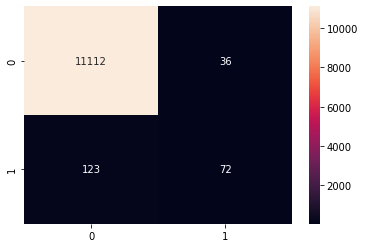

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d")

In [8]:
tp = df.loc[labels & preds, ["article_text", "text"]]

tp

,article_text,text
id,,
359377,"Eugenio Zaffaroni: ""Con Macri no hubiéramos te...",@usuario Tal vez tengas razón viejo trolo... P...
379261,"Alberto Fernández: ""Las mujeres mueven el mund...",@usuario no confundir con los travestis !\nqu...
379287,"Alberto Fernández: ""Las mujeres mueven el mund...",@usuario No seas trolo man
395359,El exabrupto de Jair Bolsonaro sobre Brasil y ...,"@usuario Tiene toda la razón, no pueden ser t..."
338100,"Vive con sus dos novios y atiende ""la policlín...","@usuario Esta gente está enferma, pobre chico ..."
...,...,...
396719,"""Te amo "". La emotiva dedicatoria de Luis Nova...",@usuario Que cara de puto recalcitrante... dir...
396732,"""Te amo "". La emotiva dedicatoria de Luis Nova...",@usuario Son osos jaja q manga de putos jaja
359559,Polémica en las redes por el actor que personi...,@usuario Como se puede ser tan trolo?


In [9]:
import pandas as pd

pd.options.display.max_rows = 150
pd.options.display.max_colwidth = 400
fn = df[labels & ~preds]

fn.loc[:, ["article_text", "text", "LGBTI_pred"]].sort_values("LGBTI_pred")

,article_text,text,LGBTI_pred
id,,,
379497,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url",@usuario Es difícil ser médico con la cabeza quemada...,0.0
379540,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url",@usuario Será porque le tienen miedo a la verdad de la biología???,0.0
379539,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url",@usuario Porque no les da la cabeza para una carrera universitaria de complejidad,0.0
379538,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url","@usuario Raro que no lleguen a ser médicos o ingenieros, son carreras duras y difíciles.\nPero nadie mejor que ellos sabe lo que es romperse el culo...",0.0
379536,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url","@usuario Amigos es ciencia emoji cara pidiendo silencio emoji no vaya a ser que se vuelvan en contra de la ideología de género, verían la verdad emoji cara pidiendo silencio emoji",0.0
379526,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url",@usuario Por que no estudian la carrera. Hasta ahora no esta prohibido estudiar para los trans,0.0
379525,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url","@usuario ""Por qué no vemos médicos con enanismo? El reclamo de un pretencioso opa para que le aplaudan su postureo moral""",0.0
379524,"""¿Por qué no vemos médicos trans?"": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | Por Valeria Román url",@usuario El único que conocí era un desastre.,0.0
396734,"""Te amo "". La emotiva dedicatoria de Luis Novaresio a su pareja en su cumpleaños url url",@usuario Sigo sin entender esta obsesión por mostrar a quién se garchan. A nadie le importa. Son peores que las minas más egocéntricas.,0.0


## Falsos negativos LGBTI

|   Contexto                      |  Comentario                                           |
|---------------------------------|-------------------------------------------------------|
| Contó que era lesbiana, su papá le confesó que era gay y ahora su madre se enamoró de una mujer, lo que inspiró su segundo film | WTF. Mucho ESI los degeneró... |
|            | @usuario Esta familia tiene los genes alterados |
|  Oscar González Oro ya está instalado en el Uruguay: "Recuperé mi libertad" | Ahora quedate allá, y hablá mal d Macri d nuevo pa tener rating. Y opiná q los taxi boy uruguayos son mas educados q los escorts argentinos! Ano abierto! |
|¿Por qué un beso entre dos hombres los vuelve tan violentos?": la vida después de haber sido víctima de ataques  homofóbicos |  Será xq va contra la naturaleza de la raza... |
| "¿Por qué no vemos médicos trans?": el reclamo de un prestigioso cardiólogo para que América sea más inclusiva | 	@usuario Es difícil ser médico con la cabeza quemada...|
| | porque un enfermo no cura a otro enfermo |
| "Te amo ". La emotiva dedicatoria de Luis Novaresio a su pareja en su cumpleaños | 🤮🤮🤮|
|                              | @usuario Para la putarracada gastan líneas? |
|Elizabeth Gómez Alcorta: "Por la pandemia, vamos a tener una suba de los femicidios y travesticidios" |  Travesticidios... Osea asesinatos de tipos con peluca y tetas |
| Mariana Genesio Peña pasa su cuarentena total con guantes, barbijo y desnuda: "Mi cuerpo es el planeta Tierra" | Coronavirus nivel pelotudo en bolas	|
| | Con 3 piernas cualquiera es feliz!!!	|
| | pasa la cuarentena rascándose las bolas |
|Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario | Cómo no saco su escopeta y aplicó la defensa propia?! |

## WOMEN

In [14]:
from sklearn.metrics import precision_recall_fscore_support

labels = df["WOMEN"]
preds = df["WOMEN_pred"] > 0.5

prec, recall, fscore, support = precision_recall_fscore_support(labels, preds, average='binary')

print("WOMEN results")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {fscore:.3f}")
print(f"Support: {df['WOMEN'].sum()}")

print(f"False negatives: {df[labels & ~preds].shape[0]}")
print(f"False negatives not found in other categories: {df[labels & ~preds & ~hateful_pred].shape[0]}")

WOMEN results
Precision: 0.651
Recall: 0.309
F1: 0.419
Support: 272
False negatives: 188
False negatives not found in other categories: 86


Como hay mucho mix acá...veamos los que no agarran con otras clases

<AxesSubplot:>

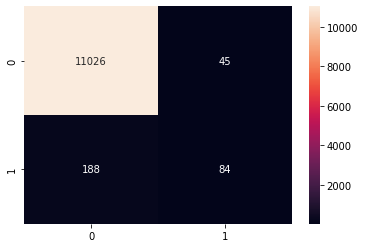

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d")

In [17]:
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400

hateful_pred = df["HATEFUL_pred"]

fn = df[labels & ~hateful_pred]

fn.sort_values("WOMEN_pred").loc[:, ["article_text", "text", "WOMEN_pred"]]

,article_text,text,WOMEN_pred
id,,,
344458,"Alicia Castro le pide al Gobierno que ""no confíe"" en la vacuna de Oxford para el coronavirus y pruebe ""la rusa, china y cubana"" url",@usuario Hagame el favor de vacunarse la argolla !,0.0
327568,Coronavirus y encierro forzoso: advierten que puede aumentar la violencia contra mujeres y niños url,@usuario Están queriendo decir que los hombres vayan a trabajar mientras ellas se rascan el orto en su casa,0.0
396734,"""Te amo "". La emotiva dedicatoria de Luis Novaresio a su pareja en su cumpleaños url url",@usuario Sigo sin entender esta obsesión por mostrar a quién se garchan. A nadie le importa. Son peores que las minas más egocéntricas.,0.0
398708,"Hebe de Bonafini criticó a los supermercados y llamó a ""suplantar la carne por arroz, garbanzos y lentejas"" url",@usuario Hay que suplantar a todas las MOMIAS de la política como HEBE ...,0.0
362684,"Leche de cucaracha, la nueva bebida nutritiva: ¿quién se anima a probarla? url",@usuario No me digas q la hija de CFK está embarazada y ya sale leche por esos senos,0.0
362677,"Leche de cucaracha, la nueva bebida nutritiva: ¿quién se anima a probarla? url","@usuario Leche de Wiñazky? Genial, que la pruebe Canosa que tiene ganas de contagiarse algo parece.",0.0
382140,"Elizabeth Gómez Alcorta: ""Por la pandemia, vamos a tener una suba de los femicidios y travesticidios"" | Por Luciana Peker url",@usuario PeKer y el virus del feminismo soberbio,0.0
354677,"Baby Etchecopar, contra las feministas: ""Convirtieron una lucha legítima en una payasada"" url url",@usuario Son una emoji caca con ojos emoji emoji caca con ojos emoji emoji caca con ojos emoji . Una peste de mente leve,0.0
403381,"Chocobar. ""Espero que se haga Justicia "", dijo la madre del ladrón muerto url url",@usuario Si. La tienen que meter presa a Ud por no abortar esa bestia cuando nació,0.0


| Contexto                         |           Texto                                                                                         |
|----------------------------------|---------------------------------------------------------------------------------------------------------|
|Martha Rosenberg: "En situación de pandemia, legalizar el aborto es más urgente que nunca" | Quien es esta vieja?. No debería estar tejiendo?|
|Mara Gómez: la historia de la primera futbolista trans en el torneo argentino  |  Feminismo pierde de nuevo... ya le metieron un tipo... jaja punto para el patriarcado...	|
|Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario | Las feministas en modo error 404 al no saber si celebrar o ofenderse |
| El desesperado pedido de Actrices Argentinas ante la violencia de género en cuarentena: "Es urgente" | Que risa me dan las feministas!!! Ignorantes.	|
| Leche de cucaracha, la nueva bebida nutritiva: ¿quién se anima a probarla? | No me digas q la hija de CFK está embarazada y ya sale leche por esos senos	|
|Los fans de Florencia Kirchner le piden casamiento por Instagram | Zoofilia|
|                                                                  | Hdp tienen que tener estomago para querer casarse con terrible adefesio |
| Rosario: para sacar una licencia de conducir habrá que hacer un curso de perspectiva de género | Te quieren adoctrinar desde cualquier ámbito, y se están metiendo en todo para que empieces a hablar como el orto, como a ellas les gusta.	|
|    | El que choca más feministas le dan más años de licencia	|
|Por qué los países liderados por mujeres parecen haber respondido mejor a la crisis del coronavirus | Son mujeres inteligentes que se dejan asesorar de sus esposos |
| Joe Biden presentó su nuevo equipo de comunicación compuesto enteramente por mujeres | Será equipe conche seque?	|



## 

## CLASS

In [20]:
from sklearn.metrics import precision_recall_fscore_support

labels = df["CLASS"]
preds = df["CLASS_pred"] > 0.5

prec, recall, fscore, support = precision_recall_fscore_support(labels, preds, average='binary')

print("CLASS results")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {fscore:.3f}")
print(f"Support: {df['CLASS'].sum()}")

print(f"False negatives: {df[labels & ~preds].shape[0]}")
print(f"False negatives not found in other categories: {df[labels & ~preds & ~hateful_pred].shape[0]}")

CLASS results
Precision: 0.677
Recall: 0.430
F1: 0.526
Support: 151
False negatives: 86
False negatives not found in other categories: 34


Ok, CLASS tiene problemitas pero no tantos

In [21]:
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400

hateful_pred = df["HATEFUL_pred"]

fn = df[labels & ~preds & ~hateful_pred]

fn.sort_values("CLASS_pred").loc[:, ["article_text", "text", "CLASS_pred"]]

,article_text,text,CLASS_pred
id,,,
354193,"El exabrupto de Dady Brieva por el banderazo: ""Unas ganas de agarrar un camión y jugar al bowling por la 9 de Julio"" url","@usuario No precisabas un camión, simplemente con la Pera los desparramabas a todos!!!",0.0
356380,El principal gremio docente nacional rechazó el regreso a las clases presenciales url,@usuario Sindicalistas Vagos de Mierda.,0.0
356374,El principal gremio docente nacional rechazó el regreso a las clases presenciales url,@usuario Parásitos caros.,0.0
379383,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas"" url",@usuario La falta de viviendas no. La delincuencia y las toma de tierras si. @usuario emoji cara de payaso emoji emoji cara de payaso emoji,0.0
379381,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas"" url",@usuario Técnicamente si,0.0
379378,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas"" url","@usuario Yo le diria a las organizaciones sociales que estan equivocadas, es un metodo valido y muy efectivo para resolver la falta de vivienda, mas si son usurpadores",0.0
379349,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas"" url","@usuario ""Queremos ver sangreee"" by abraham simpson",0.0
374029,Banderazo sin distancia social en apoyo a Alberto Fernández en la Quinta de Olivos url,@usuario Chorrea la grasa,0.0
379441,"La historia de una familia de cartoneros en la toma de Guernica: ""Por primera vez sentimos que tenemos un hogar"" url",@usuario Tienen los dias contados,0.0


| Contexto                         |           Texto                                                                                         |
|----------------------------------|---------------------------------------------------------------------------------------------------------|
| Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: "La falta de vivienda no se resuelve con balas"| La falta de viviendas no. La delincuencia y las toma de tierras si. @usuario emoji cara de payaso emoji emoji cara de payaso emoji	|
|                                  | @usuario Yo le diria a las organizaciones sociales que estan equivocadas, es un metodo valido y muy efectivo para resolver la falta de vivienda, mas si son usurpadores|
| El polémico cortejo del ladrón asesinado por el jubilado en Quilmes | La teoría de Charles Darwin en la practica.\n\nVamos COVID-19, haz tu gracia.|
| El sorteo del Mundial 2023: los Pumas buscan evitar el grupo de la muerte | EL ÚNICO GRUPO DE LA MUERTE SON LA SOCIEDAD ARGENTINA, HAY MUCHOS RESENTIDOS QUE NO LOS QUIEREN,SON LOS COLGADOS A INTERNET Y VAGOS COMIENDO POLENTA, LES METIERON ODIO Y HABLAN POR HABLAR,AHORA ESTAN A FAVOR DE LA MUERTE DE SUS PROPIAS ESPECIES JAJAJA |
| El Gobierno destinará 75 mil millones de pesos para urbanizar 300 villas en todo el país | Queee encima esto!!! Vayan a trabajar. Porque todo gratis dejen de joder	|

